# create dummy value traces propagated using either TD(0) or TD(1) and then run regression in space
### for each value trace
### take a weighted sum of the two regression outputs

In [1]:
from TD_dummy_learners import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as LR
import pandas as pd
plt.style.use("seaborn-poster")
%matplotlib qt
from scipy.stats import sem

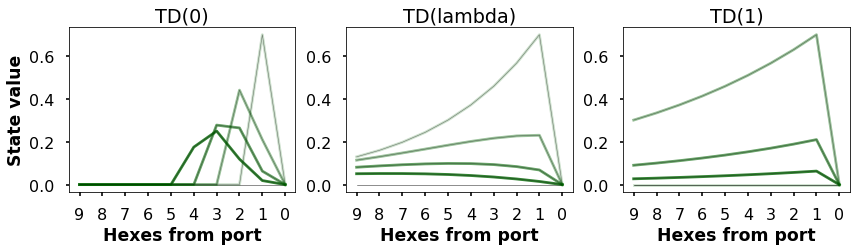

In [36]:
# use explicit rewards, same for both learners

n_tris = 5 #number of trials to plot
alpha = 0.7
gamma = .9
e_lambda = .9
pR = 100 #probability of reward
stHex = 10

dumWorld = DummyWorld(nstates = stHex,pRwd = pR)
dumWorld.initialize_world()

zeroLearner = TdDummyLearner(alpha,gamma,e_lambda=None,use_etrace=False)
zeroLearner.set_valFunc(np.zeros(dumWorld.nstates))


rwds = []
for i in range(n_tris):
    draw = np.random.randint(100)
    r = 1 if draw <= dumWorld.pRwd else 0
    rwds.append(r)
    
rwds = [0,1,0,0,0]
plt.figure(figsize=(12,3.6))
xvals = np.flip(np.arange(0,dumWorld.nstates))#np.arange(-dumWorld.nstates+1,1)
ax1 = plt.subplot(131)
plt.ylabel("State value",fontsize="xx-large",fontweight="bold")
plt.xlabel("Distance from terminal state",fontsize="xx-large",fontweight="bold")
plt.title("TD(0)")# over episodes")

t = 0
TD_0_valOverTime = [zeroLearner.V]
ax1.plot(xvals,zeroLearner.V,label='t='+str(t+1)+' r(t-1)='+str(r),c='darkgreen',alpha=1*(t/n_tris))
ax1.plot(xvals,zeroLearner.V,c='black',alpha=0.5,lw=0.5)
while t < n_tris:
    r = rwds[t]
    run_TD_episode(dumWorld,zeroLearner,r)
    ax1.plot(xvals,zeroLearner.V,label='t='+str(t+1)+' r(t-1)='+str(r),c='darkgreen',alpha=1*(t/n_tris))
    ax1.plot(xvals,zeroLearner.V,c='black',alpha=0.5,lw=0.5)
    TD_0_valOverTime.append(zeroLearner.V)
    
    t += 1
plt.xlabel("Hexes from port",fontsize="xx-large",fontweight="bold")
plt.xticks(xvals,xvals)
#ax1.legend()
ax1.invert_xaxis()

#now with etrace
lambdaLearner = TdDummyLearner(alpha,gamma,e_lambda=e_lambda,use_etrace=True)
lambdaLearner.set_valFunc(np.zeros(dumWorld.nstates))

dumWorld.create_etrace()
lambdaLearner.set_etrace(dumWorld.etrace)

ax2 = plt.subplot(132,sharey=ax1)
plt.title("TD(lambda)")# over episodes")

t = 0
ax2.plot(xvals,lambdaLearner.V,c='darkgreen',alpha=1*(t/n_tris))
ax2.plot(xvals,lambdaLearner.V,c='black',alpha=0.5,lw=0.5)
while t < n_tris:
    r = rwds[t]
    run_TD_episode(dumWorld,lambdaLearner,r)
    ax2.plot(xvals,lambdaLearner.V,c='darkgreen',alpha=1*(t/n_tris))
    ax2.plot(xvals,lambdaLearner.V,c='black',alpha=0.5,lw=0.5)
    t += 1
#plt.suptitle("alpha: "+str(alpha)+", gamma: "+str(gamma)+", lambda: "+str(e_lambda))
plt.tight_layout()
plt.xlabel("Hexes from port",fontsize="xx-large",fontweight="bold")
plt.xticks(xvals,xvals)
ax2.invert_xaxis()


#now with etrace
LA_Learner = LookAheadDummyLearner(alpha,gamma)
LA_Learner.set_valFunc(np.zeros(dumWorld.nstates))
LA_Learner.set_termVal(0)

ax3 = plt.subplot(133,sharey=ax1)
plt.title("TD(1)")# over episodes")

t = 0
run_lookAhead_episode(dumWorld,LA_Learner,r)
ax3.plot(xvals,LA_Learner.V,c='darkgreen',alpha=1*(t/n_tris))
ax3.plot(xvals,LA_Learner.V,c='black',alpha=0.5,lw=0.5)
td1vals = [LA_Learner.V.copy()]
while t < n_tris:
    r = rwds[t]
    run_lookAhead_episode(dumWorld,LA_Learner,r)
    ax3.plot(xvals,LA_Learner.V,c='darkgreen',alpha=1*(t/n_tris))
    ax3.plot(xvals,LA_Learner.V,c='black',alpha=0.5,lw=0.5)
    td1vals.append(LA_Learner.V.copy())
    t += 1
plt.xlabel("Hexes from port",fontsize="xx-large",fontweight="bold")
plt.xticks(xvals,xvals)
ax3.invert_xaxis()
plt.tight_layout()




In [25]:
def run_TD_episode(dumWorld,learner,rwd=None,pltEtrace=False):
	dumWorld.set_state(0)
	deltas = []
	if pltEtrace:
		fig = plt.figure()
		plt.plot(learner.etrace,alpha=.05/dumWorld.nstates,color='k')
	while dumWorld.state != dumWorld.term_state:
		s = dumWorld.state
		if learner.use_etrace:
			learner.update_etrace(dumWorld.state)
			if pltEtrace:
				plt.plot(learner.etrace,alpha=(s+.05)/dumWorld.nstates,color='k')
		dumWorld.take_action()
		sprime = dumWorld.state
		r = dumWorld.get_rwd(rwd)
		rpe = learner.update_valFunc(r,s,sprime)
		deltas.append(rpe)
	if pltEtrace:
		plt.ylabel("update eligibility")
		plt.xlabel("state")
		plt.tight_layout()
		return r,deltas,fig    
	return r,deltas

In [32]:
%matplotlib qt

In [34]:
lambdaLearner = TdDummyLearner(alphaTD1,gammaTD1,e_lambda=e_lambda,use_etrace=True)
lambdaLearner.set_valFunc(np.zeros(dumWorld.nstates))

dumWorld.create_etrace()
lambdaLearner.set_etrace(dumWorld.etrace)
r = 1
fig = run_TD_episode(dumWorld,lambdaLearner,r,pltEtrace=True)[2]
#fig.savefig("/Volumes/Tim/Photometry/10MfRatDataSet/exampleFitEtraceEvolution.pdf")
#fig.savefig("/Volumes/Tim/Photometry/10MfRatDataSet/exampleTD0EtraceEvolution.pdf")
#fig.savefig("/Users/Tim/Photometry/10MfRatDataSet/exampleFitEtraceEvolution.pdf")

In [13]:
# use explicit rewards, same for both learners

n_tris = 1000
alpha = 0.85#85#0.5#0.6
gamma = 0.8#.9
#gammaTD1=gamma#.8
#alphaTD1 = alpha#.5
#e_lambda = .9#0.3#0.65

alphaTD1 = 0.5#0.5#0.30#0.8#0.5
gammaTD1 = 0.8#0.87#.7
e_lambda = 1#.94


pR = 50

dumWorld = DummyWorld(nstates = 16,pRwd = pR)
dumWorld.initialize_world()

zeroLearner = TdDummyLearner(alpha,gamma,e_lambda=None,use_etrace=False)
zeroLearner.set_valFunc(np.zeros(dumWorld.nstates))


rwds = []
for i in range(n_tris):
    draw = np.random.randint(100)
    r = 1 if draw <= dumWorld.pRwd else 0
    rwds.append(r)

t = 0
TD_zero_valOverTime = [zeroLearner.V.copy()]
TD_zero_rpeOverTime = [np.zeros(dumWorld.nstates)]
while t < n_tris:
    r = rwds[t]
    rpe = run_TD_episode(dumWorld,zeroLearner,r)[1]
    TD_zero_valOverTime.append(zeroLearner.V.copy())
    TD_zero_rpeOverTime.append(rpe)
    t += 1

#now with etrace
lambdaLearner = TdDummyLearner(alphaTD1,gammaTD1,e_lambda=e_lambda,use_etrace=True)
lambdaLearner.set_valFunc(np.zeros(dumWorld.nstates))

dumWorld.create_etrace()
lambdaLearner.set_etrace(dumWorld.etrace)    

t = 0    
TD_lambda_valOverTime = [lambdaLearner.V]
TD_lambda_rpeOverTime = [np.zeros(dumWorld.nstates)]
while t < n_tris:
    r = rwds[t]
    rpe = run_TD_episode(dumWorld,lambdaLearner,r)[1]
    TD_lambda_valOverTime.append(lambdaLearner.V)
    TD_lambda_rpeOverTime.append(rpe)
    t += 1

#now with etrace
LA_Learner = LookAheadDummyLearner(alpha,gamma)
LA_Learner.set_valFunc(np.zeros(dumWorld.nstates))
LA_Learner.set_termVal(.5)

t = 0
lookAhead_valOverTime = []
while t < n_tris:
    r = rwds[t]
    run_lookAhead_episode(dumWorld,LA_Learner,r)
    lookAhead_valOverTime.append(LA_Learner.V.copy())
    t += 1

    
#create regression df with columns[stateVal,distanceToGoal,rwd,td0Val,tdLambdaVal]
regDf = pd.DataFrame({"td0Val":np.zeros(n_tris*dumWorld.nstates),"tdLambdaVal":np.zeros(n_tris*dumWorld.nstates),\
                     "td0Rpe":np.zeros(n_tris*dumWorld.nstates),"tdLambdaRpe":np.zeros(n_tris*dumWorld.nstates),\
                      "dToGoal":np.zeros(n_tris*dumWorld.nstates),"state":np.zeros(n_tris*dumWorld.nstates),\
                     "lookAheadVal":np.zeros(n_tris*dumWorld.nstates)})
for t in range(n_tris):
    regDf.loc[t*dumWorld.nstates:t*dumWorld.nstates+dumWorld.nstates-1,"td0Val"] = TD_zero_valOverTime[t]
    regDf.loc[t*dumWorld.nstates:t*dumWorld.nstates+dumWorld.nstates-1,"td0Rpe"] = [0.0]+TD_zero_rpeOverTime[t]
    regDf.loc[t*dumWorld.nstates:t*dumWorld.nstates+dumWorld.nstates-1,"tdLambdaVal"] = TD_lambda_valOverTime[t]
    regDf.loc[t*dumWorld.nstates:t*dumWorld.nstates+dumWorld.nstates-1,"tdLambdaRpe"] = [0.0] + TD_lambda_rpeOverTime[t]
    regDf.loc[t*dumWorld.nstates:t*dumWorld.nstates+dumWorld.nstates-1,"lookAheadVal"] = lookAhead_valOverTime[t]
    regDf.loc[t*dumWorld.nstates:t*dumWorld.nstates+dumWorld.nstates-1,"dToGoal"] = np.flip(np.arange(0,dumWorld.nstates))
    regDf.loc[t*dumWorld.nstates:t*dumWorld.nstates+dumWorld.nstates-1,"state"] = dumWorld.states

regDf.loc[:,"r"] = 0
regDf.loc[:,"r-1"] = -1
regDf.loc[:,"r-2"] = -1
regDf.loc[:,"r-3"] = -1
regDf.loc[:,"r-4"] = -1
regDf.loc[:,"r-5"] = -1
regDf.loc[:,"r-6"] = -1
regDf.loc[:,"r-7"] = -1
regDf.loc[:,"r-8"] = -1
regDf.loc[:,"r-9"] = -1
regDf.loc[:,"r-10"] = -1
regDf.loc[regDf.state==dumWorld.term_state,"r"]=rwds
#and lagged rewards
regDf.loc[regDf.state==dumWorld.term_state,"r-1"]=regDf.loc[regDf.state==dumWorld.term_state,"r"].shift(1)
regDf.loc[:,"r-1"] = regDf.loc[:,"r-1"].replace(-1,method='bfill')
regDf.loc[regDf.state==dumWorld.term_state,"r-2"]=regDf.loc[regDf.state==dumWorld.term_state,"r"].shift(2)
regDf.loc[:,"r-2"] = regDf.loc[:,"r-2"].replace(-1,method='bfill')
regDf.loc[regDf.state==dumWorld.term_state,"r-3"]=regDf.loc[regDf.state==dumWorld.term_state,"r"].shift(3)
regDf.loc[:,"r-3"] = regDf.loc[:,"r-3"].replace(-1,method='bfill')
regDf.loc[regDf.state==dumWorld.term_state,"r-4"]=regDf.loc[regDf.state==dumWorld.term_state,"r"].shift(4)
regDf.loc[:,"r-4"] = regDf.loc[:,"r-4"].replace(-1,method='bfill')
regDf.loc[regDf.state==dumWorld.term_state,"r-5"]=regDf.loc[regDf.state==dumWorld.term_state,"r"].shift(5)
regDf.loc[:,"r-5"] = regDf.loc[:,"r-5"].replace(-1,method='bfill')
regDf.loc[regDf.state==dumWorld.term_state,"r-6"]=regDf.loc[regDf.state==dumWorld.term_state,"r"].shift(6)
regDf.loc[:,"r-6"] = regDf.loc[:,"r-6"].replace(-1,method='bfill')
regDf.loc[regDf.state==dumWorld.term_state,"r-7"]=regDf.loc[regDf.state==dumWorld.term_state,"r"].shift(7)
regDf.loc[:,"r-7"] = regDf.loc[:,"r-7"].replace(-1,method='bfill')
regDf.loc[regDf.state==dumWorld.term_state,"r-8"]=regDf.loc[regDf.state==dumWorld.term_state,"r"].shift(8)
regDf.loc[:,"r-8"] = regDf.loc[:,"r-8"].replace(-1,method='bfill')
regDf.loc[regDf.state==dumWorld.term_state,"r-9"]=regDf.loc[regDf.state==dumWorld.term_state,"r"].shift(9)
regDf.loc[:,"r-9"] = regDf.loc[:,"r-9"].replace(-1,method='bfill')
regDf.loc[regDf.state==dumWorld.term_state,"r-10"]=regDf.loc[regDf.state==dumWorld.term_state,"r"].shift(10)
regDf.loc[:,"r-10"] = regDf.loc[:,"r-10"].replace(-1,method='bfill')



In [28]:
fig = plt.figure(figsize=(16,5))
colormap = plt.cm.get_cmap('hot',7)#'copper', 5)
colors = [colormap(i) for i in range(7)][:5]
colors = np.flip(colors,axis=0)
rDf = regDf.loc[regDf.notnull().all(axis=1),:]

reg_weights = []
dists = np.arange(1,7)
rlags = np.arange(1,6)
r_weights = []
for dist in dists:
    X = rDf.loc[rDf.dToGoal==dist,\
                  ["r-"+str(n) for n in rlags]].values
    if len(X)==0:
        break
    y = rDf.loc[rDf.dToGoal==dist,"td0Val"]
    mod = LR(fit_intercept=True,normalize=False).fit(X,y)
    r_weights.append(mod.coef_) #regression at specified distance
reg_weights.append(r_weights)  
reg_weights = np.mean(reg_weights,axis=0)

xvals = dists
plt.subplot(131)
plt.title("Local propagation")
for d in range(len(reg_weights.T)):
    plt.plot(xvals,reg_weights.T[d],marker='o',label="R(t-"+str(d+2)+")",color=colors[d])#,color='k',alpha=1-((d)/len(reg_weights.T)))
ax=plt.gca()
ax.invert_xaxis()
#plt.legend()
plt.xlabel("distance from port",fontsize='xx-large',fontweight='bold')
plt.ylabel("Reward ß",fontsize='xx-large',fontweight='bold')
plt.xticks(xvals)
plt.tight_layout()

reg_weights1 = []
r_weights = []
for dist in dists:
    X = rDf.loc[rDf.dToGoal==dist,\
                  ["r-"+str(n) for n in rlags]].values
    if len(X)==0:
        break
    y = rDf.loc[rDf.dToGoal==dist,"tdLambdaVal"]
    mod = LR(fit_intercept=True,normalize=False).fit(X,y)
    r_weights.append(mod.coef_) #regression at specified distance
reg_weights1.append(r_weights)  
reg_weights1 = np.mean(reg_weights1,axis=0)

ax1=plt.gca()
xvals = dists
plt.subplot(132)#,sharey=ax1)
plt.title("Path-wide propagation")
for d in range(len(reg_weights1.T)):
    plt.plot(xvals,reg_weights1.T[d],marker='o',label="R(t-"+str(d+2)+")",color=colors[d])#color='k',alpha=1-((d)/len(reg_weights1.T)))
ax=plt.gca()
ax.invert_xaxis()
#plt.legend()
plt.xlabel("distance from port",fontsize='xx-large',fontweight='bold')
plt.ylabel("Reward ß",fontsize='xx-large',fontweight='bold')
plt.xticks(xvals)
plt.tight_layout()

ax1=plt.gca()
xvals = dists
plt.subplot(133)#,sharey=ax1)
plt.title("Combination")
for d in range(len(reg_weights1.T)):
    plt.plot(xvals,0.2*reg_weights.T[d]+0.8*reg_weights1.T[d],marker='o',\
             label="R(t-"+str(d+2)+")",color=colors[d])#,color='k',alpha=1-((d)/len(reg_weights1.T)))
ax=plt.gca()
ax.invert_xaxis()
#plt.legend()
plt.xlabel("distance from port",fontsize='xx-large',fontweight='bold')
plt.ylabel("Reward ß",fontsize='xx-large',fontweight='bold')
plt.xticks(xvals)
plt.tight_layout()

In [73]:
fig.savefig("/Volumes/Tim/Photometry/10MfRatDataSet/dummyRhistRegPlots.pdf")

In [29]:
fig.savefig("/Volumes/Tim/Photometry/10MfRatDataSet/dummyRhistRegPlots_forCombo.pdf")

In [15]:
rDf = regDf.loc[regDf.notnull().all(axis=1),:]

reg_weights = []
dists = np.arange(1,6)
rlags = np.arange(1,6)
r_weights = []
for dist in dists:
    X = rDf.loc[rDf.dToGoal==dist,\
                  ["r-"+str(n) for n in rlags]].values
    if len(X)==0:
        break
    y = rDf.loc[rDf.dToGoal==dist,"td0Val"]
    mod = LR(fit_intercept=True,normalize=False).fit(X,y)
    r_weights.append(mod.coef_) #regression at specified distance
reg_weights.append(r_weights)  
#reg_weights = np.mean(reg_weights,axis=0)

xvals=['R(t-1)','R(t-2)','R(t-3)','R(t-4)','R(t-5)']
fig = plt.figure(figsize=(5,7))
plt.bar(xvals,np.argmax(reg_weights,axis=1)[0]+1,alpha=.5,color='teal')
plt.ylabel("Distance of peak effect on value (a.u.)",fontsize=20)
plt.xlabel("Prior reward at port",fontsize=20)
plt.yticks(np.arange(0,6),fontsize=16)
plt.tight_layout()
#fig.savefig("/Volumes/Tim/Photometry/9ratDataSet/dummyTD0distOfPeakRwd.pdf")

([<matplotlib.axis.YTick at 0x7f7be06af710>,
 <a list of 6 Text yticklabel objects>)

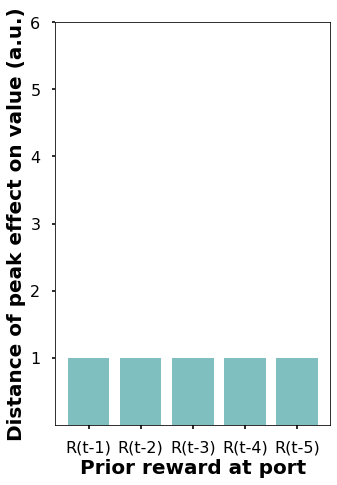

In [6]:
rDf = regDf.loc[regDf.notnull().all(axis=1),:]

reg_weights = []
dists = np.arange(1,10)
rlags = np.arange(1,6)
r_weights = []
for dist in dists:
    X = rDf.loc[rDf.dToGoal==dist,\
                  ["r-"+str(n) for n in rlags]].values
    if len(X)==0:
        break
    y = rDf.loc[rDf.dToGoal==dist,"tdLambdaVal"]
    mod = LR(fit_intercept=True,normalize=False).fit(X,y)
    r_weights.append(mod.coef_) #regression at specified distance
reg_weights.append(r_weights)  
#reg_weights = np.mean(reg_weights,axis=0)

xvals=['R(t-1)','R(t-2)','R(t-3)','R(t-4)','R(t-5)']
fig = plt.figure(figsize=(5,7))
plt.bar(xvals,np.argmax(reg_weights,axis=1)[0]+1,alpha=.5,color='teal')
plt.ylabel("Distance of peak effect on value (a.u.)",fontsize=20,fontweight='bold')
plt.xlabel("Prior reward at port",fontsize=20,fontweight='bold')
plt.tight_layout()
plt.yticks(np.arange(1,7))
#plt.ylim(0,5.3)
#fig.savefig("/Volumes/Tim/Photometry/9ratDataSet/dummyTD1distOfPeakRwd.pdf")

In [18]:
combinedRweights = 0.3*np.array(reg_weights).T+0.7*np.array(reg_weights1).T

In [22]:
rDf.loc[:,'comboVal'] = 0.3*rDf['td0Val'].copy()+0.7*rDf['tdLambdaVal'].copy()

In [24]:
rDf = regDf.loc[regDf.notnull().all(axis=1),:]
rDf.loc[:,'comboVal'] = 0.3*rDf['td0Val'].copy()+0.7*rDf['tdLambdaVal'].copy()

reg_weights = []
dists = np.arange(1,6)
rlags = np.arange(1,6)
r_weights = []
for dist in dists:
    X = rDf.loc[rDf.dToGoal==dist,\
                  ["r-"+str(n) for n in rlags]].values
    if len(X)==0:
        break
    y = rDf.loc[rDf.dToGoal==dist,"comboVal"]
    mod = LR(fit_intercept=True,normalize=False).fit(X,y)
    r_weights.append(mod.coef_) #regression at specified distance
reg_weights.append(r_weights)  
#reg_weights = np.mean(reg_weights,axis=0)

xvals=['R(t-1)','R(t-2)','R(t-3)','R(t-4)','R(t-5)']
fig = plt.figure(figsize=(5,7))
plt.bar(xvals,np.argmax(reg_weights,axis=1)[0]+1,alpha=.5,color='teal')
plt.ylabel("Distance of peak effect on value (a.u.)",fontsize=20)
plt.xlabel("Prior reward at port",fontsize=20)
plt.yticks(np.arange(0,6),fontsize=16)
plt.tight_layout()

/Users/timkrausz/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/timkrausz/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [25]:
fig.savefig("/Volumes/Tim/Photometry/10MfRatDataSet/dummyComboModelDistOfPeakRwd.pdf")